# Reformat Dan's Data
I'm not sure if our model is performing poorly because of our data, so I'm going to reformat Dan's data and try to use that.

In [41]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
data_dict = pd.read_pickle('data/mcts7500_pool.pickle')

In [58]:
x = data_dict['board_x']
y = data_dict['play_y']
print(data_dict['README'])

this is with MCTS7500 - but it looks for wins and blocks before doing mcts..all boards are saved assuming that the next move is plus - this works by saving -1*board when it is minus turn...


In [44]:
# convert to 6x7x2 shape
def convert_shape(board):
    """
    Convert a 6x7 board with 1s, -1s, and 0s into a 6x7x2format.
    
    The first channel ([:,:,0]) marks where the 1s are.
    The second channel ([:,:,1]) marks where the -1s are.
    
    Args:
        board (numpy.ndarray): 6x7 array with values -1, 0, and 1.

    Returns:
        numpy.ndarray: 6x7x2 array.
    """
    new_board = np.zeros((6, 7, 2), dtype=int)
    new_board[:, :, 0] = (board == 1)  # Mark 1s in first channel
    new_board[:, :, 1] = (board == -1) # Mark -1s in second channel
    return new_board

x = [convert_shape(arr) for arr in x]

# create new df
df = pd.DataFrame({'x':x, 'y':y})

# Double size of dataset by flipping boards
def flip_board(board, col):
    new_board = np.flip(board, axis = 1) # axis 1 = columns
    new_column = 6 - col
    return new_board, new_column
flipped_x = []
flipped_y = []
for index, row in df.iterrows():
    board = row['x']
    col = row['y']
    new_board, new_column = flip_board(board, col)
    flipped_x.append(new_board)
    flipped_y.append(new_column)
new_df = pd.DataFrame({"x": flipped_x, "y": flipped_y})

# Append the df of flipped boards
df = pd.concat([df, new_df], ignore_index = True)
print(len(df))

# Create tuple to look into removing data
df['x_tuple'] = df['x'].apply(lambda x:tuple(x.ravel())) 
display(df)

531240


,x,y,x_tuple
0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",6,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
531235,"[[[0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [0, ...",6,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, ..."
531236,"[[[0, 0], [0, 0], [0, 0], [0, 1], [1, 0], [1, ...",6,"(0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ..."
531237,"[[[0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [0, ...",1,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, ..."
531238,"[[[0, 0], [0, 0], [0, 0], [0, 1], [1, 0], [1, ...",2,"(0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ..."


There are 453376 unique x's in our dataset.
85.34% of the x's are unique in our dataset.


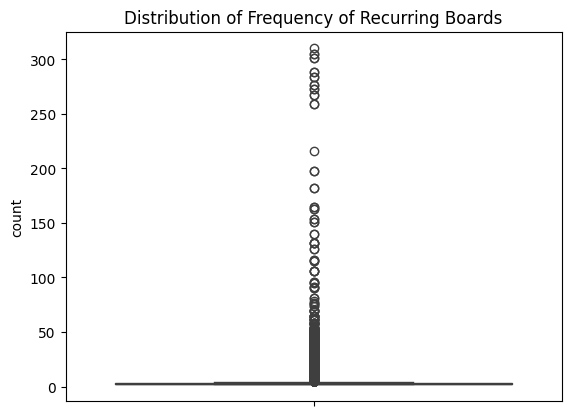

Most recurring boards only occur twice, but some occur as many as 300 times.
There are 24212 recurring boards that we could potentially restrict moves for.


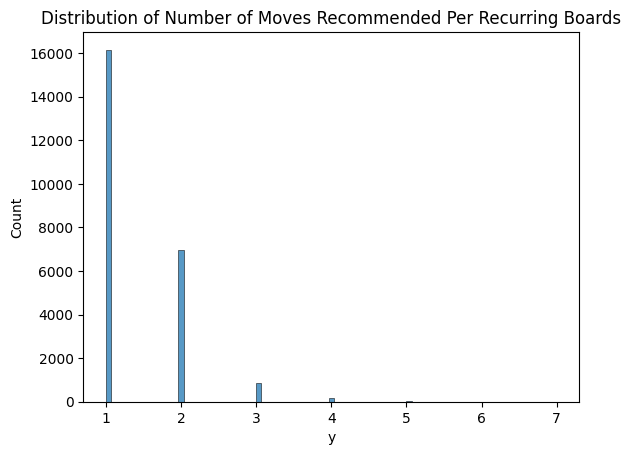

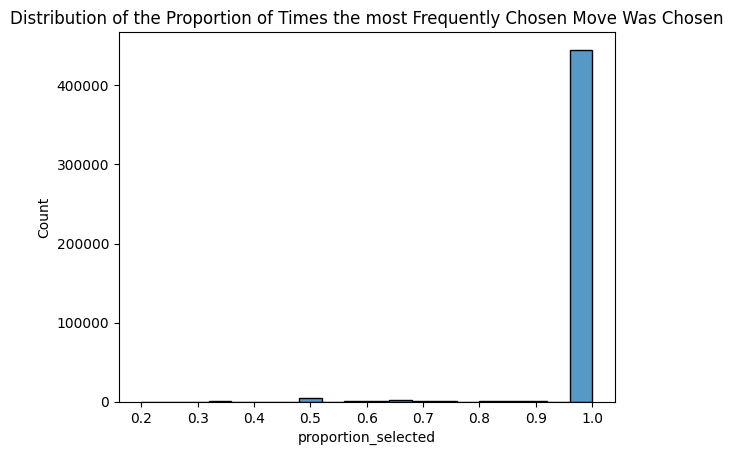

This is for recurring and non-recurring boards. If a board doesn't occur multiple times, then the most frequently occurring move is selected 1/1 times.


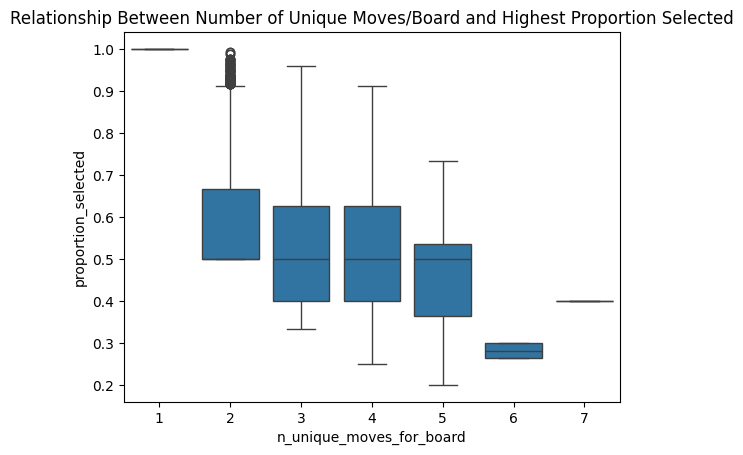

In [45]:
# examine games

# unique x's?
unique_x = df['x_tuple'].nunique()
print(f'There are {unique_x} unique x\'s in our dataset.')
perc_unique_x = unique_x / df.shape[0] * 100
print(f'{perc_unique_x:.2f}% of the x\'s are unique in our dataset.')

# How often do recurring boards occur?
board_counts = df['x_tuple'].value_counts()
sns.boxplot(board_counts[board_counts>1])
plt.title('Distribution of Frequency of Recurring Boards')
plt.show()
print('Most recurring boards only occur twice, but some occur as many as 300 times.')

# For repeated boards, what is the consensus among moves?
recurring_boards_s = pd.Series(board_counts[board_counts > 1].index)
print(f'There are {len(recurring_boards_s)} recurring boards that we could potentially restrict moves for.')
recurring_boards_df = df[df['x_tuple'].isin(recurring_boards_s)]
n_moves = recurring_boards_df.groupby('x_tuple')['y'].nunique()
sns.histplot(n_moves)
plt.title('Distribution of Number of Moves Recommended Per Recurring Boards')
plt.show()

moves_counts_df = df.groupby('x_tuple')['y'].value_counts().reset_index()
total_moves = df.groupby('x_tuple')['y'].count().reset_index().rename(columns = {'y':'total_moves'})
moves_counts_df = moves_counts_df.merge(total_moves, on='x_tuple')
moves_counts_df['proportion_selected'] = moves_counts_df['count'] / moves_counts_df['total_moves']

# Distribution of the proportion of times the most frequently chosen moves
sns.histplot(moves_counts_df.groupby('x_tuple')['proportion_selected'].max())
plt.title('Distribution of the Proportion of Times the most Frequently Chosen Move Was Chosen')
plt.show()
print('This is for recurring and non-recurring boards. If a board doesn\'t occur multiple times, then the most frequently occurring move is selected 1/1 times.')

# Get the most frequent move for all boards
most_frequent_moves_df = moves_counts_df.loc[moves_counts_df.groupby('x_tuple')['proportion_selected'].idxmax()]

# record the most frequent move for each board
move_mapping = most_frequent_moves_df.set_index('x_tuple')['y']
df['most_frequent_move'] = df['x_tuple'].map(move_mapping)

# record the selection rate for the most frequent move for each board
proportion_mapping = most_frequent_moves_df.set_index('x_tuple')['proportion_selected']
df['most_frequent_move_prop_selected'] = df['x_tuple'].map(proportion_mapping)

# record the number of unique moves for each board
n_moves = df.groupby('x_tuple')['y'].nunique()
df['n_unique_moves_for_board'] = df['x_tuple'].map(n_moves)

# Look at how the proportion selected is related to the number of unique moves per board
plot_df = df[df['most_frequent_move']==df['y']].drop_duplicates(subset='x_tuple') # only look at boards where the most frequent move won
plot_df = plot_df.merge(most_frequent_moves_df[['x_tuple', 'proportion_selected']], on='x_tuple')
sns.boxplot(x = plot_df['n_unique_moves_for_board'], y = plot_df['proportion_selected'])
plt.title('Relationship Between Number of Unique Moves/Board and Highest Proportion Selected')
plt.show()

In [46]:
# choose the most frequently selected move for repeating boards
df = df[df['y'] == df['most_frequent_move']].drop_duplicates(subset=['x_tuple', 'y'])
print(len(df))

453376


In [50]:
df = df[['x', 'y']]

In [51]:
df.to_pickle('data/MCTS7500_6-7-2shape_cleaned.pkl')

In [52]:
# testing it worked
# df = pd.read_pickle('data/MCTS7500_6-7-2shape_cleaned.pkl')
# display(df)

,x,y
0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4
1,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4
2,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",5
3,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3
4,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",6
...,...,...
531235,"[[[0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [0, ...",6
531236,"[[[0, 0], [0, 0], [0, 0], [0, 1], [1, 0], [1, ...",6
531237,"[[[0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [0, ...",1
531238,"[[[0, 0], [0, 0], [0, 0], [0, 1], [1, 0], [1, ...",2
